In [1]:
import pandas as pd
import nltk
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
#nltk.download('stopwords')
#nltk.download('punkt')

In [3]:
stopwords = nltk.corpus.stopwords.words('english')
data = pd.read_csv('annotations_metadata.csv', na_values = ['idk/skip'], index_col = 'file_id')
data.dropna(axis = 0, inplace = True)

In [30]:
#train
def getCommonWords(filenames):
    words = []
    for file in filenames:
        ifile = open('./all_files/' + file + '.txt')
        try:
            words.extend(nltk.word_tokenize(ifile.read()))
        except:
            continue
        ifile.close()
    filtered_words = []
    for word in words:
        word = porter.stem(word)
        if word.isalpha() and len(word)>3 and word not in stopwords:
            filtered_words.append(word)
    return filtered_words

temp = data.head(math.floor(len(data)*0.7))

filenames = temp[temp.label == 'noHate'].index
possible_nonhate_words = getCommonWords(filenames)

filenames = temp[temp.label == 'hate'].index
possible_hate_words = getCommonWords(filenames)

word_frequencies = dict()
for w, c in Counter(possible_hate_words).most_common(100):
    for x in Counter(possible_nonhate_words).most_common(100):
        if w in x:
            break
    else:
        word_frequencies[w] = c
print(word_frequencies)

{'negro': 65, 'hate': 32, 'kill': 24, 'scum': 23, 'africa': 22, 'women': 21, 'asian': 21, 'brown': 20, 'immigr': 20, 'liber': 20, 'stop': 19, 'hell': 19, 'crime': 19, 'hous': 18, 'homosexu': 18, 'cultur': 17, 'monkey': 17, 'soon': 16, 'jewish': 16, 'themselv': 16, 'citi': 16, 'muslim': 15, 'anim': 15, 'becom': 15, 'someth': 15, 'street': 15, 'leav': 15, 'filth': 14, 'walk': 14, 'town': 14, 'move': 14, 'seem': 13, 'human': 13, 'news': 13, 'happen': 13, 'irish': 13, 'real': 13, 'stand': 13, 'murder': 13, 'stupid': 12, 'hand': 12, 'woman': 12}


In [31]:
vulgar_words = word_frequencies.keys()
word_neighbours = {}
for file in filenames:
    ifile = open('./all_files/'+file+'.txt')
    try:
        file_contents = ifile.read()
    except:
        continue
    x = nltk.word_tokenize(file_contents)
    for i in range(len(x)):
        word = porter.stem(x[i])
        if word in vulgar_words:
            if word not in word_neighbours:
                word_neighbours[word] = x[i-3:i+4]
            else:
                word_neighbours[word].extend(x[i-3:i+4])

In [32]:
#predict
test_file_count = math.ceil(len(data)*0.3)
filenames = data.tail(test_file_count).index
results = dict()
for file in filenames:
    ifile = open('./all_files/'+file+'.txt')
    try:
        file_contents = ifile.read()
    except:
        continue
    score, count = 0, 0
    x = nltk.word_tokenize(file_contents)
    for i in range(len(x)):
        word = porter.stem(x[i])
        if word not in stopwords and word.isalpha() and len(word)>3:
            count += 1
            score += word_frequencies.get(word, 0)
        if word in vulgar_words:
            for _ in x[i-2:i+3]:
                if _ in word_neighbours[word]:
                    score += 25
    if count != 0:
        avg_score = score/count
    else:
        avg_score = 0
    results[file] = avg_score

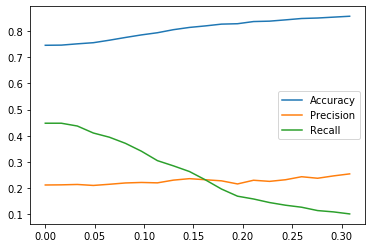

In [33]:
#analyse
max_score = max(results.values())
accuracy, precision, recall, cutoffs = list(), list(), list(), list()
for i in range(20):
    tp, tn, fp, fn = 0, 0, 0, 0
    cutoff = i/max_score
    for k,v in results.items():
        normal_score = v/max_score
        if normal_score > cutoff:
            if data.loc[k, 'label'] == 'hate':
                tp += 1
            else:
                fp += 1
        else:
            if data.loc[k, 'label'] == 'noHate':
                tn += 1
            else:
                fn += 1
    accuracy.append((tp+tn)/(tp+tn+fp+fn))
    precision.append(tp/(tp+fp))
    recall.append(tp/(tp+fn))
    cutoffs.append(cutoff)
plt.plot(cutoffs, accuracy, label = 'Accuracy')
plt.plot(cutoffs, precision, label = 'Precision')
plt.plot(cutoffs, recall, label = 'Recall')
plt.legend()
plt.show()